# PyPAD example

In [1]:
from collections import Counter
from random import uniform

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pypad.graphics.biometric_performance import performance_evaluation
from pypad.graphics.det_plot import DETPlot
from pypad.metrics.det_curve import det_curve_pais, eer_pais
from pypad.metrics.iso_30107_3 import acer, apcer_pais, bpcer, bpcer_ap
from pypad.metrics.scores import pad_scores

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Threshold

The threshold is the operating point with which we will evaluate the PAD system. A score higher than this means the biometric pattern matches the target. We will set the threshold to 0.5 for this example; feel free to change it and see how it is reflected in the metrics.

In [2]:
threshold = 0.5

## Scores

Scores can be loaded from *.txt* files, or from a *.csv* file with “**label;score**”. format. For this example, we will load some bona fide and attack scores from two files. The attack scores label will be set to “0”, and the bona fide scores label will be set to “1”.

In [3]:
with open("attack.txt") as f:
    attack_scores = np.array([float(i) for i in f.read().split()])

with open("bonafide.txt") as f:
    bonafide_scores = np.array([float(i) for i in f.read().split()])

# Generate labels arrays
attack_true = np.zeros(attack_scores.shape, dtype=np.uint8)
bonafide_true = np.ones(bonafide_scores.shape, dtype=np.uint8)
bonafide_label = 1

# If the scores were all in a single sequence, you can use the split_scores() function
# to separate them into separate arrays, as long as you also have an array with the
# labels. Here is a commented example of how you could do that by reading the scores
# from a .csv file:
# with open(csv_file) as f:
#     reader = csv.reader(f)
#     y_true, y_score = zip(*reader)
# attack_scores, bonafide_scores, attack_true, bonafide_true = split_scores(
#     y_true, y_score, bonafide_label=1
# )

print(
    f"   Attack presentations: {Counter(attack_true)}\n"
    f"Bona fide presentations: {Counter(bonafide_true)}"
)

   Attack presentations: Counter({0: 50000})
Bona fide presentations: Counter({1: 5988})


## Attack Presentation Classification Error Rate (APCER)

$ APCER_{PAIS}(\tau) = 1 - (\frac{1}{N_{PAIS}}) \sum_{i=1}^{N_{PAIS}} RES_i $

In this example, we evaluate the APCER using the defined threshold. The result of the `apcer_pais()` function is a dictionary where the key is the label for the attack instrument, and the value is the error rate for that class. The dictionary will have as many entries as attack instruments that you have, in this case it is only one.

Please notice that the APCER at a threshold of 0.5 is around 86%, that means that 86% of all attack presentations are incorrectly classified as bona fide by the biometric system, meaning that 0.5 is not a good threshold to choose.

In [4]:
apcer_t = apcer_pais(attack_true, attack_scores, threshold=threshold, percentage=True)
print(f"APCER({threshold}) = {apcer_t}(%)")

APCER(0.5) = {0: 86.246}(%)


## Bona Fide Presentation Classification Error Rate (BPCER)

$ BPCER(\tau) = \frac{\sum_{i=1}^{N_{BF}} RES_{i}}{N_{BF}} $

In this example, we evaluate the BPCER at the defined threshold using the `bpcer()` function. Since we are using percentages, we multiply the result by 100.

Notice that the BPCER is very low, at 0.1169%. This means that very few bona fide presentations will be incorrectly classified as attack presentations.

In [5]:
bpcer_t = bpcer(bonafide_scores, threshold=threshold)
print(f"BPCER({threshold}): {bpcer_t * 100}%")

BPCER(0.5): 0.11690046760187041%


## Equal Error Rate (EER)

The EER is the point at which the security (APCER) and convinience (BPCER) measures are balanced.

For this, we use the `det_curve_pais()` function, which computes the APCER and BPCER across a series of operating points for each different PAIS. This will help us find the operating point at which the APCER and BPCER are equal. Afterwards, we give the results to the `eer_pais()` function, that returns the EER value and its corresponding threshold for each species.

In [6]:
det_pais = det_curve_pais(attack_true, attack_scores, bonafide_scores)
eer_pais_ = eer_pais(det_pais, percentage=True)
for pais in eer_pais_:
    print(f"EER[{pais}]: {eer_pais_[pais][0]}%\tTHRESHOLD: {eer_pais_[pais][1]}")

EER[0]: 5.528000000300004%	THRESHOLD: 0.58714499999925


### APCER and BPCER at the EER operating point

In this example, we will simply use the `apcer_pais()` and the `bpcer()` functions again, but we will use the EER operating point instead of the previously defined one (0.5). This will result in equal (or very close to equal) values for both functions. The first two lines are simply a generic way to extract the EER threshold for the PAIS with the highest EER value, since we should always evaluate the system considering the attack presentation class with the worst performance. In this case there is only PAIS, but as said before, this is a generic approach, and should work even if there is more than one PAIS. Also note that the APCER at the EER threshold is 5.526%, which is much more aceptable than the high 86% at a threshold of 0.5. This will be visually explained later in the Biometric Performance section.

In [7]:
max_eer = max(eer_pais_.keys(), key=(lambda k: eer_pais_[k]))
eer_thres = eer_pais_[max_eer][1]

apcer_err = apcer_pais(attack_true, attack_scores, threshold=eer_thres, percentage=True)
print(f"APCER({eer_thres}): = {apcer_err}(%)")

bpcer_err = bpcer(bonafide_scores, threshold=eer_thres)
print(f"BPCER({eer_thres}): {bpcer_err * 100}%")

APCER(0.58714499999925): = {0: 5.526}(%)
BPCER(0.58714499999925): 5.527722110888444%


## Detection Error Tradeoff (DET) Curve

The DET curve is used to visually evaluate the performance of different operating points and the tradeoff between safety (APCER) and convenience (BPCER) in a PAD system. The DET plot is very useful for assessing the behaviour of the system, and to help determine a good operating point for it.

Note that each PAIS (in this case there is only one, with the label “0”) will be labeled alongside the APCER value at the EER operating point, which visually corresponds to the intersection between the PAIS curve and the ERR curve (depicted in grey). Also important are the two vertical black dashed lines, which correspond to the BPCER<sub>5</sub>, BPCER<sub>10</sub> values.

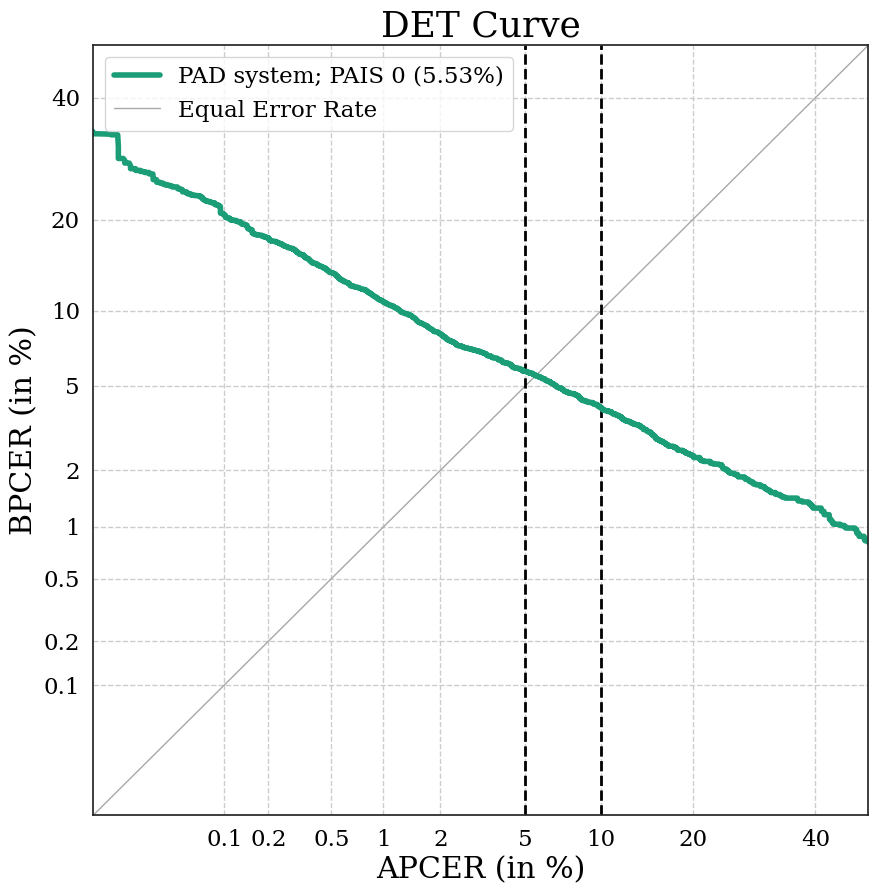

In [8]:
det = DETPlot(title="DET Curve")
det.set_system_pais(attack_true, attack_scores, bonafide_scores, label="PAD system")
det_ = det.plot()
plt.show()

Typically, the classification performance of a PAD mechanism is reported as the BPCER given at a fixed APCER. For example, the BPCER when the APCER is 5% is reported as BPCER<sub>20</sub>, and the the BPCER when the APCER is 10% is reported as BPCER<sub>10</sub>. These two values are usually reported in the PAD literatue, and serve as a comparison point to other PAD systems.

In this example, we will use the `bpcer_ap()` function to compute the BPCER<sub>5</sub>, BPCER<sub>10</sub>, BPCER<sub>20</sub>, BPCER<sub>100</sub>, BPCER<sub>1000</sub>, and BPCER<sub>10000</sub> values (again, considering the PAIS with the worst performance). You should be able to notice that the BPCER<sub>20</sub> and BPCER<sub>10</sub> values are approximately 5.76% and 3.99%, which correspond exactly to the intersection between the PAIS curve and the two black dashed lines in the above DET plot. 

In [9]:
apcer_points, bpcer_points, thresholds = det_pais[max_eer]

bpcer5, bpcer5_thres = bpcer_ap(apcer_points, bpcer_points, thresholds, 5)
bpcer10, bpcer10_thres = bpcer_ap(apcer_points, bpcer_points, thresholds, 10)
bpcer20, bpcer20_thres = bpcer_ap(apcer_points, bpcer_points, thresholds, 20)
bpcer100, bpcer100_thres = bpcer_ap(apcer_points, bpcer_points, thresholds, 100)
bpcer1000, bpcer1000_thres = bpcer_ap(apcer_points, bpcer_points, thresholds, 1000)
bpcer10000, bpcer10000_thres = bpcer_ap(apcer_points, bpcer_points, thresholds, 10000)

print(
    f"    BPCER5(APCER=20.0%): {bpcer5 * 100}%\n\tThreshold: {bpcer5_thres}\n"
    f"   BPCER10(APCER=10.0%): {bpcer10 * 100}%\n\tThreshold: {bpcer10_thres}\n"
    f"   BPCER20(APCER=5.00%): {bpcer20 * 100}%\n\tThreshold: {bpcer20_thres}\n"
    f"  BPCER100(APCER=1.00%): {bpcer100 * 100}%\n\tThreshold: {bpcer100_thres}\n"
    f" BPCER1000(APCER=0.10%): {bpcer1000 * 100:}%\n\tThreshold: {bpcer1000_thres}\n"
    f"BPCER10000(APCER=0.01%): {bpcer10000 * 100}%\n\tThreshold: {bpcer10000_thres}\n"
)

    BPCER5(APCER=20.0%): 2.371409485637943%
	Threshold: 0.560119999999373
   BPCER10(APCER=10.0%): 3.991315965263864%
	Threshold: 0.5754399999993033
   BPCER20(APCER=5.00%): 5.761523046092187%
	Threshold: 0.589124999999241
  BPCER100(APCER=1.00%): 10.771543086172342%
	Threshold: 0.6158849999991192
 BPCER1000(APCER=0.10%): 20.610665775423048%
	Threshold: 0.64869499999897
BPCER10000(APCER=0.01%): 33.451385529409336%
	Threshold: 0.6805849999988247



## Average Classification Error Rate

$ ACER(\tau) = \frac{\max(APCER_{PAIS}(\tau)) + BPCER(\tau)}{2} $

The ACER is the average of the APCER and BPCER of the PAD subsystem. **This metric is not compliant with the ISO/IEC 30107-3 standard**. Instead, the BPCER given a fixed APCER should be reported.

In this example, the ACER is evaluated using the defined threshold and the threshold corresponding to the EER.

In [10]:
acer_t = acer(attack_true, attack_scores, bonafide_scores, threshold=threshold)
acer_eer = acer(attack_true, attack_scores, bonafide_scores, threshold=eer_thres)

print(f"ACER({threshold}): {acer_t * 100}%\nACER({eer_thres}): {acer_eer * 100}%")

ACER(0.5): 43.18145023380093%
ACER(0.58714499999925): 5.526861055444222%


## Biometric Performance Evaluation

By plotting the distributions of presentation attacks vs. bona fide presentations, one can visualize the decision threshold and how it affects system performance. A properly calibrated system minimizes false rejections and false acceptances of biometric patterns. In this example, the distributions are plotted using the threshold defined above, and then the threshold corresponding to the EER.

The `performance_evaluation()` function requires a pandas dataframe, and in turn, a dataframe requires padded scores. A `pad_scores()` function is included in the library to make this easier.

In the following two plots, you will be able to visually notice the effect of choosing different operating points for the system.

In [11]:
padded_attack_scores, padded_bonafide_scores = pad_scores(
    attack_scores, bonafide_scores
)
df = pd.DataFrame(
    {
        "Bona fide scores": padded_bonafide_scores,
        "Attack presentation scores": padded_attack_scores,
    }
)

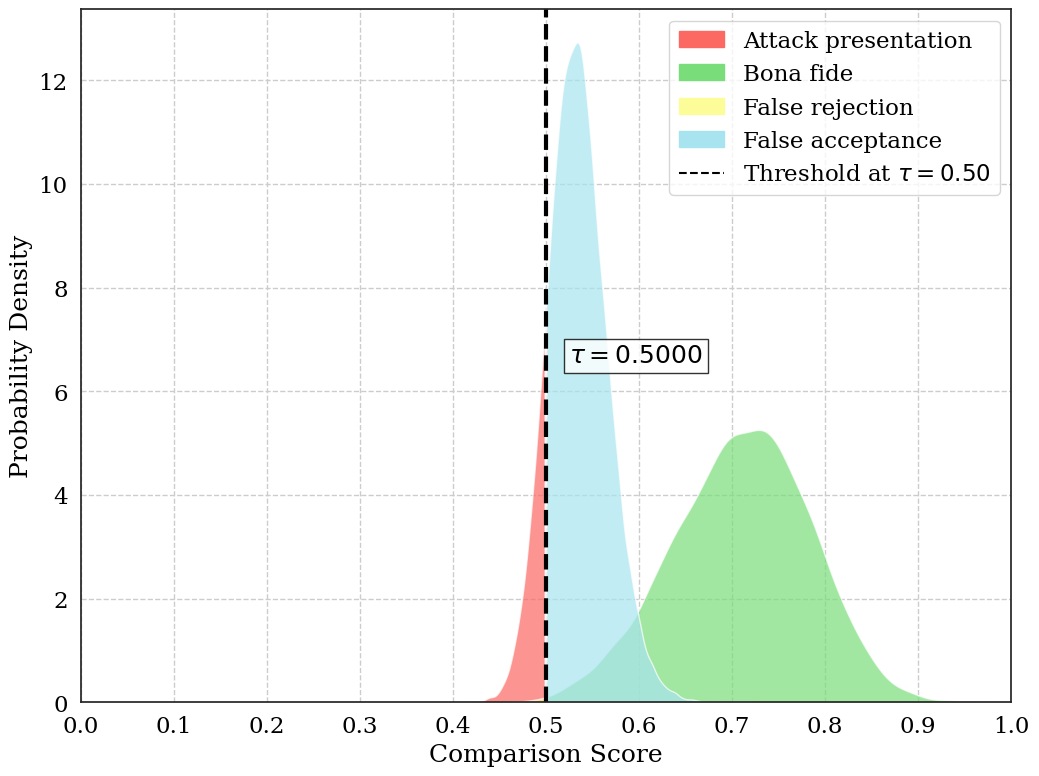

In [12]:
kde = performance_evaluation(df, threshold=threshold)
plt.show()

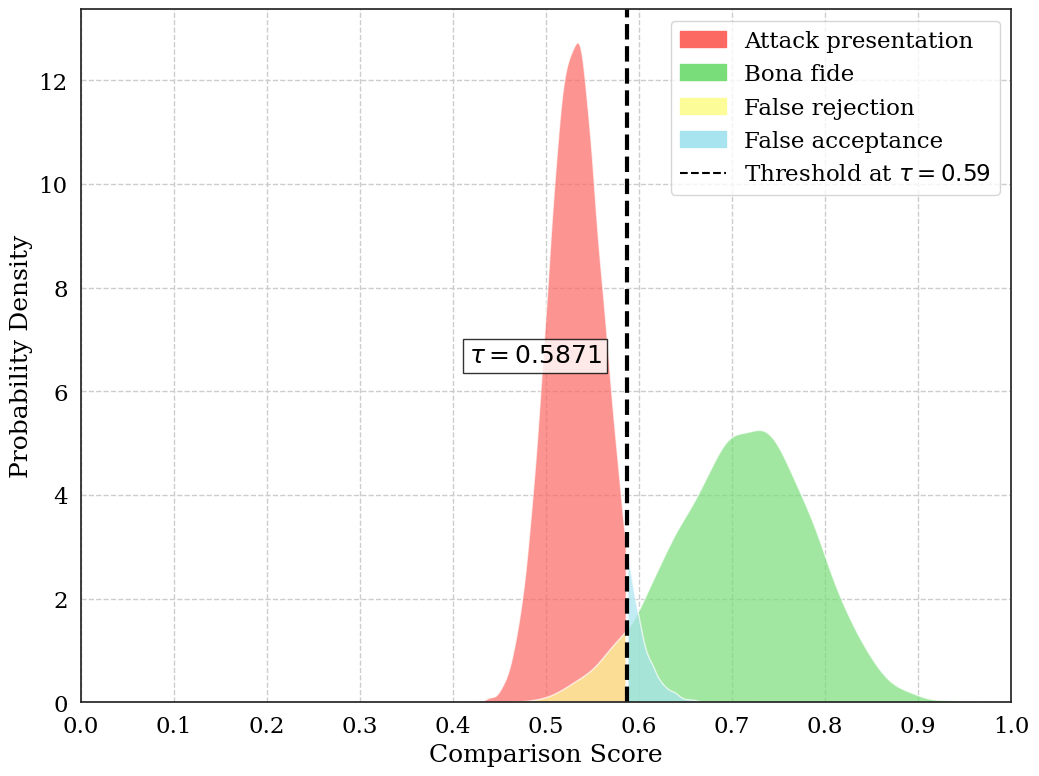

In [13]:
kde = performance_evaluation(df, threshold=eer_thres)
plt.show()

### logaritmic scale in the Y-axis

Identical to the previous example, but a logarithmic scale is used for the Y axis. This can help in cases where the distributions are too small.

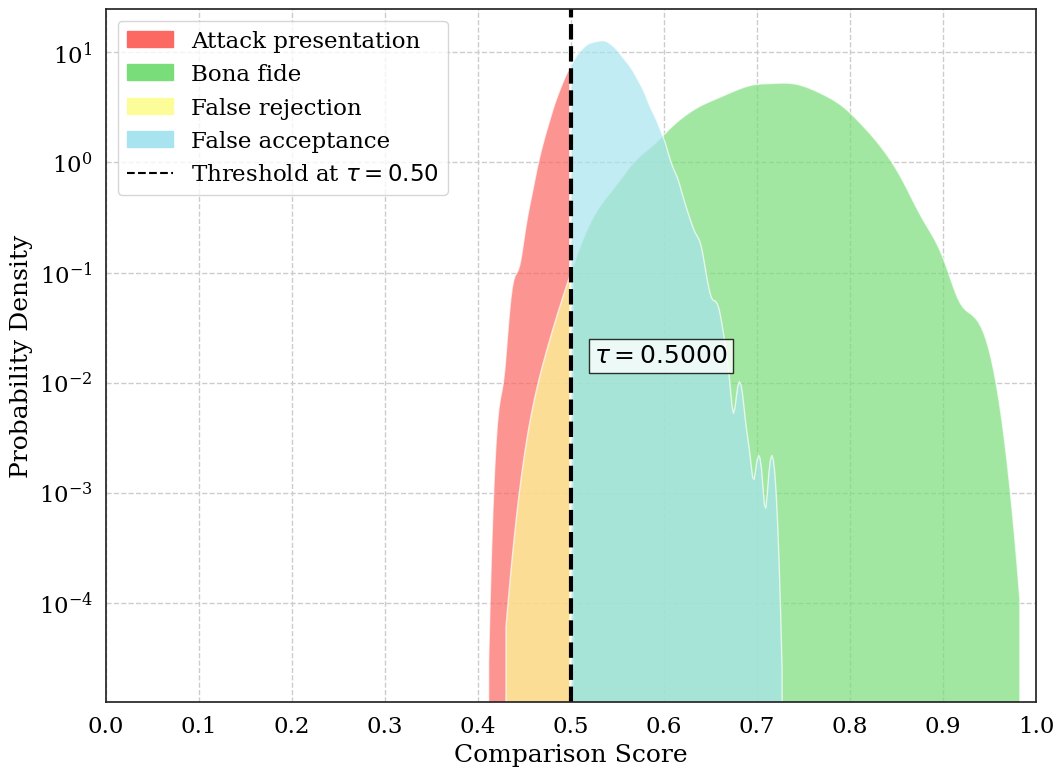

In [14]:
kde_plot_log = performance_evaluation(df, threshold=threshold, log_scale=True)
plt.show()

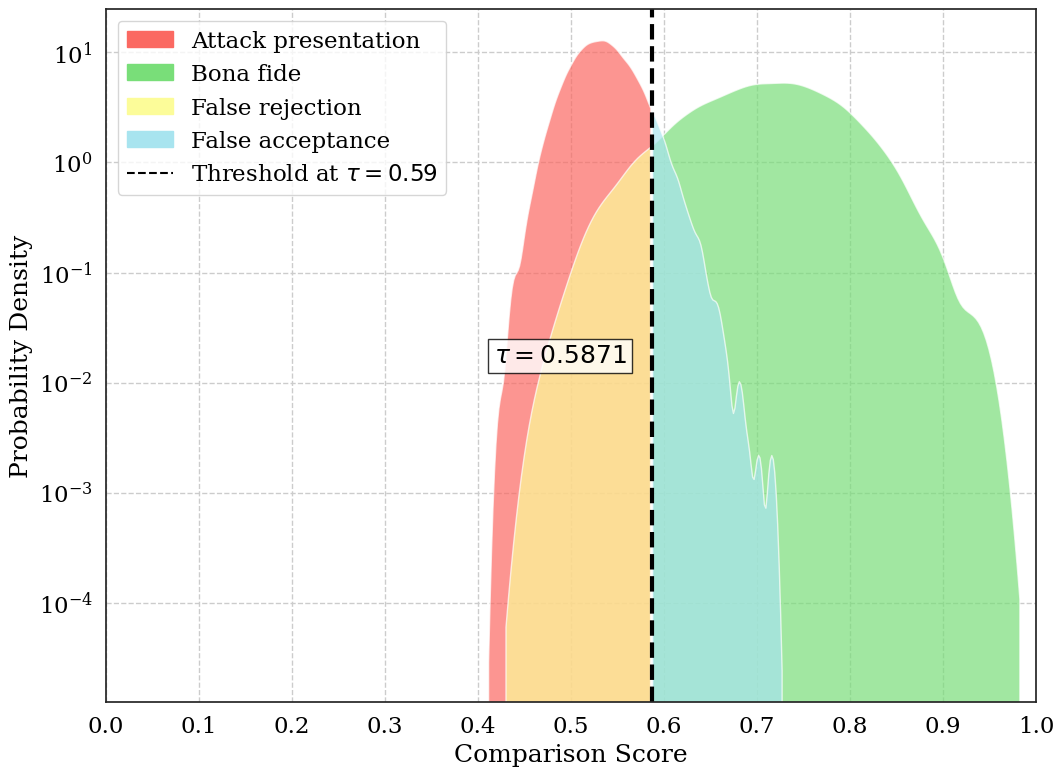

In [15]:
kde_plot_log = performance_evaluation(df, threshold=eer_thres, log_scale=True)
plt.show()

That is it! This is not a complete showcase of the PyPAD library, but it should help to get you started. We will update this with more examples in the future. For any questions, feel free to contact the authors.

## References

[1] ISO/IEC JTC 1/SC 37 Biometrics, “ISO/IEC 30107-3, Information technology — Biometric presentation attack detection — Part 3: Testing and reporting,” International Organization for Standardization, 2021.

[2] C. Busch, “What is a presentation attack? and how do we detect it?” Jan 2018. [Online]. Available: https://christoph-busch.de/files/Busch-TelAviv-PAD-180116.pdf